# Contrastive Learning for the Muller-Brown Potential

In [1]:
import numpy as np
from functions import *
from sys import exit
import sys

import argparse
from scipy.interpolate import BSpline 
from scipy import optimize
import matplotlib as mpl
from matplotlib import cm
from functions import *

#pathfinding
import sys
import os as os
d = os.path.abspath('')
tremcdir = d[:-7] + "/output/"
sys.path.append(tremcdir)
#sys.path.append("/home/gridsan/dingxq/my_package_on_github/CLCG")

#plotting functions
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

First, import all the functions as nessesary, and set up proper pathes. Load and visualize the data, a range.pkl file essentially only explains the range of the data, but we can visualize the Muller-Brown potential as a contour plot as well.

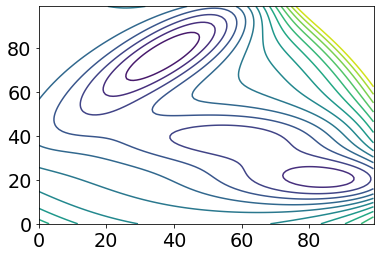

-1.5 1.0 -0.5 2.0


In [20]:
with open(tremcdir + "range.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
x1_min, x1_max = data['x1_min'], data['x1_max']
x2_min, x2_max = data['x2_min'], data['x2_max']

Z = data['U']

plt.contour(Z, levels = 20)
plt.show()

print(data['x1_min'], data['x1_max'], data['x2_min'],  data['x2_max'])
#Z is essentially a grid, where Z[0][2] gives the value at (0, 2), but 
#normalized with respect to x1 and x2


Generate samples from uniform distributions with range $x_{\_max}$ and $x_{\_max}$ as defined below. Alpha is a constant that has the physical interpretation of being $\alpha = \frac{1}{k_b T}$. Also, we can visiual the distribution of $\vec{x}$ to be a uniform distribution with specified range.

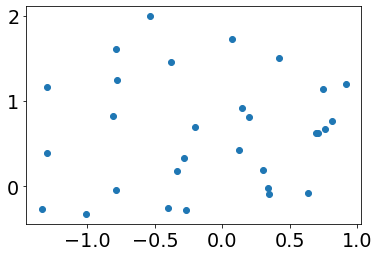

In [24]:
alpha = 0.05 

num_samples = 30    
x1 = np.random.rand(num_samples)*(x1_max - x1_min) + x1_min
x2 = np.random.rand(num_samples)*(x2_max - x2_min) + x2_min
x = np.vstack([x1, x2]).T

plt.clf()
plt.scatter(x1, x2)
plt.show()


We are attempting to learn the Muller-Brown potential function $U(\vec{x})$, where $\vec{x}$ is the position of a particle. For Boltzmann Statistics, $P(\vec{x}) \propto e^{-U(\vec{x})} = \frac{e^{-U(\vec{x})}}{\sum e^{-U(\vec{x})}}$. Maximum likelihood estimation or contrastive learning can be used to learn the parameters of the distribution, in other words, an approximation of $U(x)$. However, contrastive learning is much more efficient since it can simply estimate the partition function.

A question is how to parameterize $U(x)$. While $U(x)$ could be parameterized by a neural network, neural networks are not convex functions, so optimization might be non-trivial. $U(x)$ can be also parameterized by a cublic spline.

## How to Use Cublic Splines and Design Matricies

Source: http://publish.illinois.edu/liangf/files/2016/05/Note_splines.pdf

A cubic spline is a function with $n$ knots. The knots are equally spaced points on the range $[a, b]$, and they are: 

$a < \xi_1 < \xi_2 < ... < \xi_n < b$. 

The spline function:

$$g(x) = ax^3 + bx^2 + cx + d, x \in [\xi_{i}, \xi_{i+1}]$$

And $g$ is continous up to the second derivative. 

To represent $g$, with $n$ knots, it may appear that we need $4 \cdot n$ parameters, since there is a value of $a$, $b$, $c$, $d$ for each of the knots. However, considering that $g$ is continuous to the second derivative, then there are three constraints for each of the knots. With four variables and three equations, there is actually only one degree of freedom for each of the knots. $4(n+1) -3n = n+4$ free parameters. 

From above we are assuming a cublic spline with one knot has only has two intervals, thats whey there are $m + 4$ free parameters. 

## Function Space and Basis Functions

Functions themselves can be though of vectors since they satisfy the constraint for vector spaces, and this is true of cubic functions as well: Assume that $g_1(x)$ and $g_2(x)$ are cubic splines. $a \cdot g_1(x) + b \cdot g_2(x)$ is also a cubic spline. Therefore cublic splines span a function space, of dimensions $(m+4)$.

What are the basis functions for this function space? 

Consider that $g(x) = ax + bx^2 + cx^3 + d$ Then g(x) is a linear combination of $x$, $x^2$, $x^3$, and $1$. Then the basis functions for the first interval:

$$h_0(x) = 1$$
$$h_1(x) = x$$
$$h_2(x) = x^2$$
$$h_3(x) = x^3$$
$$h_{i+3} =(x-\xi_i)^3_+,   \  i \in \{1, 2, ..., m\}$$

The term $$h_{i+3} =(x-\xi_i)^3_+$$ is a bit tricky to derive, but consider that: 

So a cubic spline $f(x) = \beta_0 + \sum \limits_{i=1}^{m+3} \beta_j \cdot h_j(x)$





## Design Matrix

Source: https://www.uio.no/studier/emner/matnat/ifi/nedlagte-emner/INF-MAT5340/v05/undervisningsmateriale/kap2-new.pdf

A design matrix is in the form 

$$y = \bf{X} \beta$$

Where $y$ is a vector of predicted outputs, $\bf{X}$ is a design matrix, and $\beta$ is a vector of the model's coefficients.

It is possible to rewrite a b-spline as a matrix vector product. 

In [37]:
def compute_cubic_spline_basis(x, extent = (x1_min, x1_max, x2_min, x2_max)):
    x1_min, x1_max, x2_min, x2_max = extent
    
    ## degree of spline
    k = 3

    ## knots of cubic spline
    t1 = np.linspace(x1_min, x1_max, 10) 
    t2 = np.linspace(x2_min, x2_max, 10)

    ## number of basis along each dimension
    n1 = len(t1) - 2 + k + 1
    n2 = len(t2) - 2 + k + 1

    ## preappend and append knots
    t1 = np.concatenate(
        (np.array([x1_min for i in range(k)]),
         t1,
         np.array([x1_max for i in range(k)])
        ))

    t2 = np.concatenate(
        (np.array([x2_min for i in range(k)]),
         t2,
         np.array([x2_max for i in range(k)])
        ))

    spl1_list = []
    for i in range(n1):
        c1 = np.zeros(n1)
        c1[i] = 1.0
        spl1_list.append(BSpline(t1, c1, k, extrapolate = False))

    spl2_list = []
    for i in range(n2):
        c2 = np.zeros(n2)
        c2[i] = 1.0
        spl2_list.append(BSpline(t2, c2, k, extrapolate = False))

    x1, x2 = x[:, 0], x[:, 1]
    y1 = np.array([spl1(x1) for spl1 in spl1_list]).T
    y2 = np.array([spl2(x2) for spl2 in spl2_list]).T

    y = np.matmul(y1[:,:,np.newaxis], y2[:, np.newaxis, :])
    y = y.reshape(x1.shape[0], -1)
    
    return y

In [38]:
def bs(x, knots, boundary_knots, degree = 3, intercept = False):
    knots = np.concatenate([knots, boundary_knots])
    knots.sort()

    augmented_knots = np.concatenate([np.array([boundary_knots[0] for i in range(degree + 1)]),
                                      knots,
                                      np.array([boundary_knots[1] for i in range(degree + 1)])])
    num_of_basis = len(augmented_knots) - 2*(degree + 1) + degree + 1

    spl_list = []
    for i in range(num_of_basis):
        coeff = np.zeros(num_of_basis)
        coeff[i] = 1.0
        spl = BSpline(augmented_knots, coeff, degree, extrapolate = False)
        spl_list.append(spl)

    design_matrix = np.array([spl(x) for spl in spl_list]).T

    ## if the intercept is Fales, drop the first basis term, which is often
    ## referred as the "intercept". Note that np.sum(design_matrix, -1) = 1.
    ## see https://cran.r-project.org/web/packages/crs/vignettes/spline_primer.pdf
    if intercept is False:
        design_matrix = design_matrix[:, 1:]
        
    return design_matrix

In [39]:
def compute_design_matrix(x, x1_knots, x2_knots, x1_boundary_knots, x2_boundary_knots):
    x1_design_matrix = bs(x[:,0], x1_knots, x1_boundary_knots)
    x2_design_matrix = bs(x[:,1], x2_knots, x2_boundary_knots)
    x_design_matrix = x1_design_matrix[:,:,np.newaxis] * x2_design_matrix[:,np.newaxis,:]
    x_design_matrix = x_design_matrix.reshape([x_design_matrix.shape[0], -1])
    return x_design_matrix

# Contrastive Learning

Recall $P(\vec{x}) \propto e^{-U(\vec{x})}$. We now have a form for $U(\vec{x})$, so we can learn $P(\vec{x})$ to optimize for the parameters of $U(\vec{x})$. Here, $X_p$ is a set of observations from the true distribution, and $X_q$ is a set of observations from the noise distribution. 

Below the samples are initialized, and the knots for the splines are calculated.

In [40]:
## samples from p
with open(tremcdir + 'TREMC/x_record_alpha_{:.3f}.pkl'.format(alpha), 'rb') as file_handle:
    data = pickle.load(file_handle)

xp = data['x_record'][:, -1, :]

num_samples_p = xp.shape[0]
## samples from q
## these samples are from a "uniform" noise distribution 
num_samples_q = num_samples_p
x1_q = np.random.rand(num_samples_q)*(x1_max - x1_min) + x1_min
x2_q = np.random.rand(num_samples_q)*(x2_max - x2_min) + x2_min
xq = np.vstack([x1_q, x2_q]).T

x1_knots = np.linspace(x1_min, x1_max, num = 10, endpoint = False)[1:]
x2_knots = np.linspace(x2_min, x2_max, num = 10, endpoint = False)[1:]

x1_boundary_knots = np.array([x1_min, x1_max])
x2_boundary_knots = np.array([x2_min, x2_max])

xp_design_matrix = compute_design_matrix(xp, x1_knots, x2_knots, x1_boundary_knots, x2_boundary_knots)
xq_design_matrix = compute_design_matrix(xq, x1_knots, x2_knots, x1_boundary_knots, x2_boundary_knots)

In [48]:
print(xp_design_matrix)
print(np.shape(xp_design_matrix))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(50000, 196)


We can visualize the distribution of $X_p$ and $X_q$. Below, $X_q$ has 50,000 points but we plot 1000 of them.

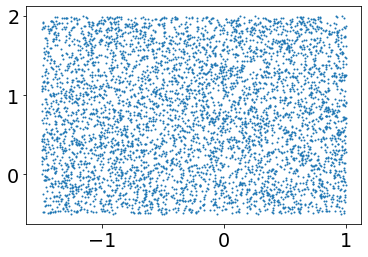

In [41]:
plt.clf()
plt.scatter(x1_q[1:5000], x2_q[1:5000], s=1)
plt.show()

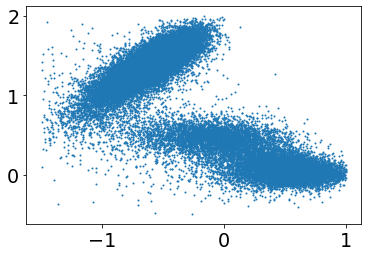

In [42]:
plt.clf()
plt.scatter(xp[:, 0], xp[:, 1], s=1)
plt.show()

A quick note on the notation: logq_xp is $\log q(x_p)$.

hellow world


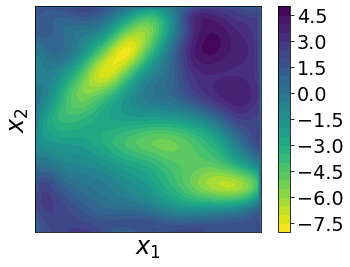

In [56]:
theta = np.random.randn(xp_design_matrix.shape[-1])
F = np.zeros(1)

def compute_loss_and_grad(thetas, regularization='L1'):
    theta = thetas[0:xp_design_matrix.shape[-1]]
    F = thetas[-1]

    up_xp = np.matmul(xp_design_matrix, theta)
    logp_xp = -(up_xp - F)
    logq_xp = np.ones_like(logp_xp)*np.log(1/((x1_max - x1_min)*(x2_max - x2_min)))

    up_xq = np.matmul(xq_design_matrix, theta)
    logp_xq = -(up_xq - F)
    logq_xq = np.ones_like(logp_xq)*np.log(1/((x1_max - x1_min)*(x2_max - x2_min)))

    nu = num_samples_q / num_samples_p
    
    G_xp = logp_xp - logq_xp
    G_xq = logp_xq - logq_xq

    h_xp = 1./(1. + nu*np.exp(-G_xp))
    h_xq = 1./(1. + nu*np.exp(-G_xq))

    if regularization == None:
        loss = -(np.mean(np.log(h_xp)) + nu*np.mean(np.log(1-h_xq))) 
    elif regularization == 'L1':
        loss = -(np.mean(np.log(h_xp)) + nu*np.mean(np.log(1-h_xq))) + 0.001*theta
    else: #regularization == 'L2':
        loss = -(np.mean(np.log(h_xp)) + nu*np.mean(np.log(1-h_xq))) + np.linalg.norm(theta)**2


    dl_dtheta = -(np.mean((1 - h_xp)[:, np.newaxis]*(-xp_design_matrix), 0) +
                  nu*np.mean(-h_xq[:, np.newaxis]*(-xq_design_matrix), 0))
    dl_dF = -(np.mean(1 - h_xp) + nu*np.mean(-h_xq))

    return loss, np.concatenate([dl_dtheta, np.array([dl_dF])])

thetas_init = np.concatenate([theta, F])
loss, grad = compute_loss_and_grad(thetas_init)

thetas, f, d = optimize.fmin_l_bfgs_b(compute_loss_and_grad,
                                 thetas_init,
                                 iprint = 1000)
#                                 factr = 10)

print("hellow world")
theta = thetas[0:xp_design_matrix.shape[-1]]
F = thetas[-1]

x_grid = generate_grid(x1_min, x1_max, x2_min, x2_max, size = 100)
x_grid_design_matrix = compute_design_matrix(x_grid, x1_knots, x2_knots, x1_boundary_knots, x2_boundary_knots)
up = np.matmul(x_grid_design_matrix, theta)
up = up.reshape(100, 100)
up = up.T

fig, axes = plt.subplots()
plt.contourf(up, levels = 30, extent = (x1_min, x1_max, x2_min, x2_max), cmap = cm.viridis_r)
plt.xlabel(r"$x_1$", fontsize = 24)
plt.ylabel(r"$x_2$", fontsize = 24)
plt.tick_params(which='both', bottom=False, top=False, right = False, left = False, labelbottom=False, labelleft=False)
plt.colorbar()
plt.tight_layout()
axes.set_aspect('equal')
plt.show()


In [ ]:

thetas_init = np.concatenate([theta, F])
loss, grad = compute_loss_and_grad(thetas_init)

thetas, f, d = optimize.fmin_l_bfgs_b(compute_loss_and_grad,
                                 thetas_init,
                                 iprint = 1)
#                                 factr = 10)
theta = thetas[0:xp_design_matrix.shape[-1]]
F = thetas[-1]

x_grid = generate_grid(x1_min, x1_max, x2_min, x2_max, size = 100)
x_grid_design_matrix = compute_design_matrix(x_grid, x1_knots, x2_knots, x1_boundary_knots, x2_boundary_knots)
up = np.matmul(x_grid_design_matrix, theta)
up = up.reshape(100, 100)
up = up.T

fig, axes = plt.subplots()
plt.contourf(up, levels = 30, extent = (x1_min, x1_max, x2_min, x2_max), cmap = cm.viridis_r)
plt.xlabel(r"$x_1$", fontsize = 24)
plt.ylabel(r"$x_2$", fontsize = 24)
plt.tick_params(which='both', bottom=False, top=False, right = False, left = False, labelbottom=False, labelleft=False)
plt.colorbar()
plt.tight_layout()
axes.set_aspect('equal')
plt.show()

In [49]:
print(xp_design_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Sampling with TREMC